## Introduction <a name="introduction"></a>

The goal of feature engineering is simply to make your data better suited to the problem at hand. You might perform feature engineering to improve a model's predictive performance reduce computational or data needs or improve interpretability of the results.

For a feature to be useful, it must have a relationship to the target that your model is able to learn. Linear models, for instance, are only able to learn linear relationships. So, when using a linear model, your goal is to transform the features to make their relationship to the target linear. The key idea here is that a transformation you apply to a feature becomes in essence a part of the model itself.  Whatever relationships your model can't learn, you can provide yourself through transformations. As you develop your feature set, think about what information your model could use to achieve its best performance.


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor

df = pd.read_csv("ames.csv")
df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YearSold,SaleType,SaleCondition,SalePrice
0,One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,141.0,31770.0,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,Corner,...,0.0,No_Pool,No_Fence,NaN,0.0,5,2010,WD,Normal,215000
1,One_Story_1946_and_Newer_All_Styles,Residential_High_Density,80.0,11622.0,Pave,No_Alley_Access,Regular,Lvl,AllPub,Inside,...,0.0,No_Pool,Minimum_Privacy,NaN,0.0,6,2010,WD,Normal,105000
2,One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,81.0,14267.0,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,Corner,...,0.0,No_Pool,No_Fence,Gar2,12500.0,6,2010,WD,Normal,172000
3,One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,93.0,11160.0,Pave,No_Alley_Access,Regular,Lvl,AllPub,Corner,...,0.0,No_Pool,No_Fence,NaN,0.0,4,2010,WD,Normal,244000
4,Two_Story_1946_and_Newer,Residential_Low_Density,74.0,13830.0,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,Inside,...,0.0,No_Pool,Minimum_Privacy,NaN,0.0,3,2010,WD,Normal,189900


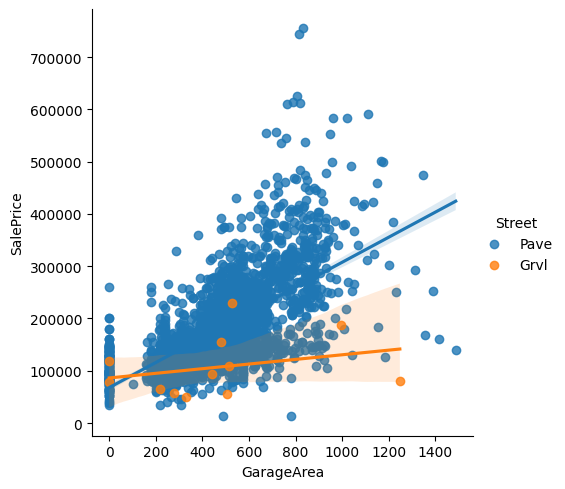

In [3]:
import seaborn as sns
sns.lmplot(x="GarageArea", y="SalePrice", hue="Street", data=df);

#### Step 1: Establish a Baseline - Training Model on original data

In [4]:
X = df.copy()
y = X.pop("SalePrice")

# Train and score baseline model
def score_dataset(X, y, model=XGBRegressor()):
    # Label encoding for categoricals
    for colname in X.select_dtypes(["category", "object"]):
        X[colname], _ = X[colname].factorize()
    # Metric for Housing competition is RMSLE (Root Mean Squared Log Error)
    score = cross_val_score(
        model, X, y, cv=5, scoring="neg_mean_squared_log_error",
    )
    score = -1 * score.mean()
    score = np.sqrt(score)
    return score

print(f"MAE Baseline Score: {score_dataset(X,y):.4}")

MAE Baseline Score: 0.1434


## Mutual Information <a name="paragraph1"></a>

To find out which features are more useful than others a feature utility metric can be used. This is a function measuring associations between a feature and the target. In the following we will use 'Mutual Information' as this metric, which is similar to correlation.
In comparision to correlation it not only detects linear relationships (correlation is based on covariance, which is basically a scalarproduct), but any relationship. Mutual information is
* easy to use and interpret,
* computationally efficient,
* theoretically well-founded,
* resistant to overfitting, and,
* able to detect any kind of relationship

Mutual information describes relationships in terms of uncertainty. The mutual information (MI) between two quantities is a measure of the extent to which knowledge of one quantity reduces uncertainty about the other. If you knew the value of a feature, how much more confident would you be about the target?



Mathematically the mutual information is the Kullbach-Leibler-divergence between the joint distribution $P_{(X,Y)}$ and the outer product distribution of the marginals, i.e. $P_X \otimes P_Y$:

$I(X,Y)=KL(P_{(X,Y)}|P_X \otimes P_Y$)

The least possible mutual information between quantities is 0.0. When MI is zero, the quantities are independent: neither can tell you anything about the other. Conversely, in theory there's no upper bound to what MI can be. In practice though values above 2.0 or so are uncommon. (Mutual information is a logarithmic quantity, so it increases very slowly.)

Here are some things to remember when applying mutual information:

* MI can help you to understand the relative potential of a feature as a predictor of the target, considered by itself.
* It's possible for a feature to be very informative when interacting with other features, but not so informative all alone. MI can't detect interactions between features. It is a univariate metric.
* The actual usefulness of a feature depends on the model you use it with. A feature is only useful to the extent that its relationship with the target is one your model can learn. Just because a feature has a high MI score doesn't mean your model will be able to do anything with that information. You may need to transform the feature first to expose the association.

#### Example:

In [5]:
# scikit-learn MI-scoring treats discrete variables different from continuous variables and needs to know which are which

# Label encoding for categoricals
for colname in X.select_dtypes("object"):
    X[colname], _ = X[colname].factorize()

# All discrete features should now have integer dtypes (double-check this before using MI!)
discrete_features = X.dtypes == int

from sklearn.feature_selection import mutual_info_regression

def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)   # _regression since y is continuous (else _classif)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

mi_scores = make_mi_scores(X, y, discrete_features)
mi_scores  # show a few features with their MI scores

OverallQual     0.587218
Neighborhood    0.567847
GrLivArea       0.496904
YearBuilt       0.438051
GarageArea      0.417625
                  ...   
PoolArea        0.000504
Utilities       0.000172
LandSlope       0.000006
PoolQC          0.000001
MoSold          0.000000
Name: MI Scores, Length: 78, dtype: float64

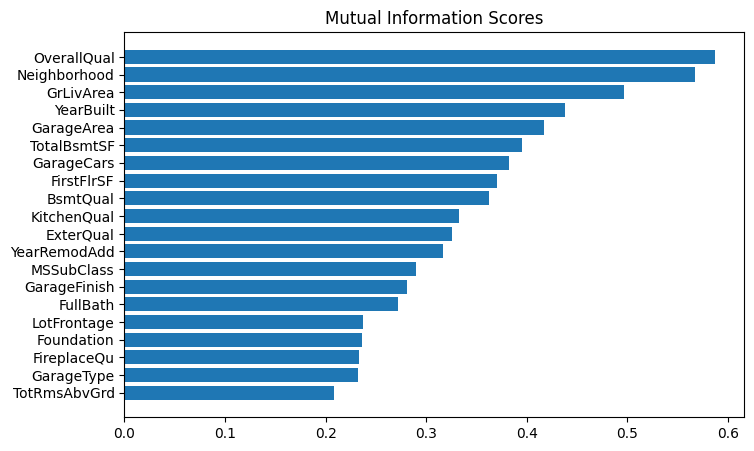

In [6]:
import matplotlib.pyplot as plt
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")


plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores.head(20))

The BldgType feature didn't get a very high MI score. A plot confirms that the categories in BldgType don't do a good job of distinguishing values in SalePrice (the distributions look fairly similar, in other words):

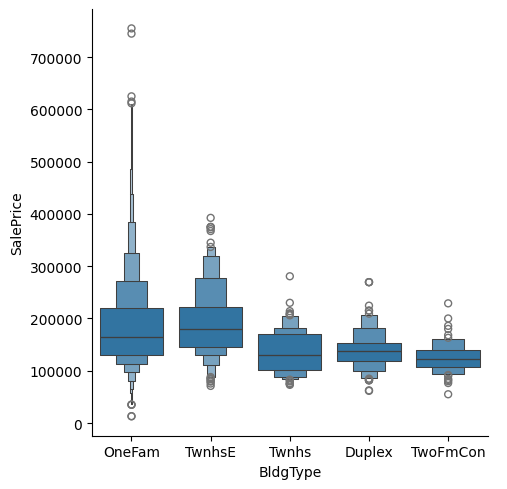

In [7]:
sns.catplot(x="BldgType", y="SalePrice", data=df, kind="boxen");

The Bldg_Type feature has a fairly low MI score, but as we can see from the following figure, it separates price populations with different trends within the GrLivArea feature. This indicates that Bldg_Type contributes an interaction effect and might not be unimportant after all. Before deciding a feature is unimportant from its MI score, it's good to investigate any possible interaction effects -- domain knowledge can offer a lot of guidance here.

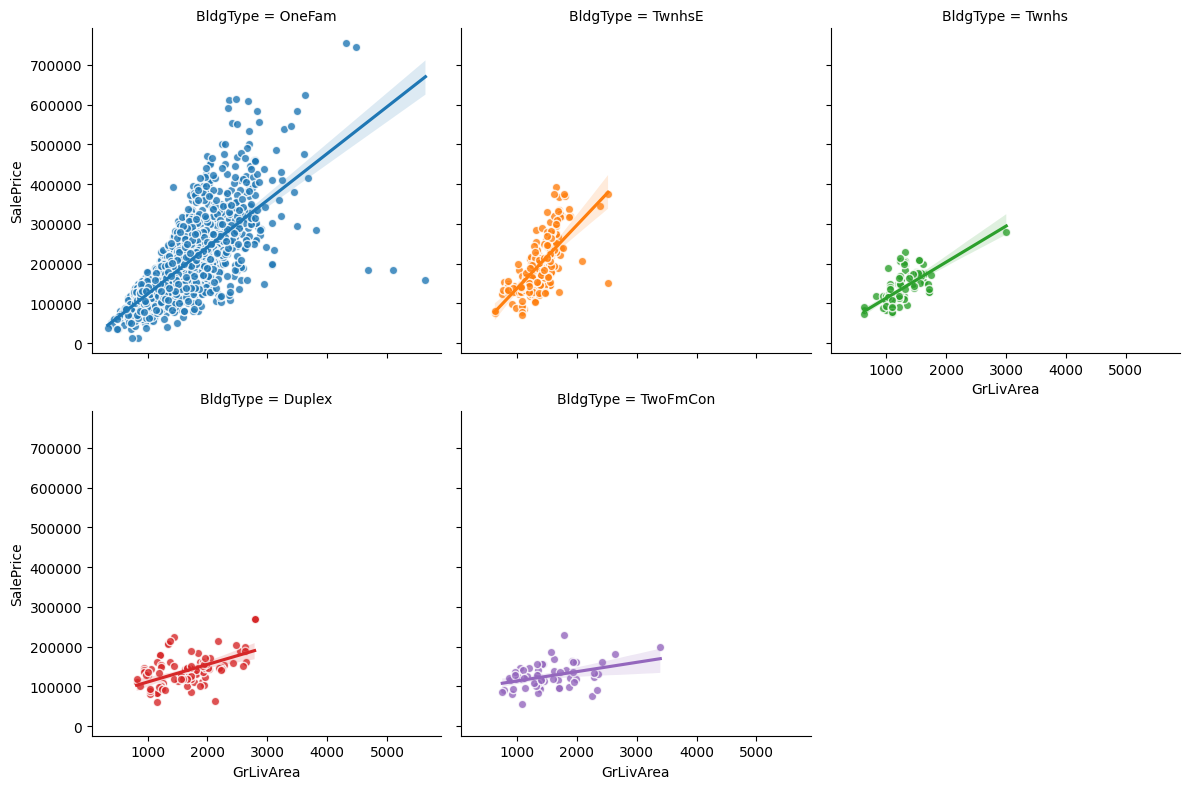

In [8]:
import seaborn as sns
feature = "GrLivArea"

sns.lmplot(
    x=feature, y="SalePrice", hue="BldgType", col="BldgType",
    data=df, scatter_kws={"edgecolor": 'w'}, col_wrap=3, height=4,
);

## Creating Features <a name="paragraph2"></a>

Tips on Creating Features
* It's good to keep in mind your model's own strengths and weaknesses when creating features. Here are some guidelines:
* Linear models learn sums and differences naturally, but can't learn anything more complex.
* Ratios seem to be difficult for most models to learn. Ratio combinations often lead to some easy performance gains.
* Linear models and neural nets generally do better with normalized features. Neural nets especially need features scaled to values not too far from 0. Tree-based models (like random forests and XGBoost) can sometimes benefit from normalization, but usually much less so.
* Tree models can learn to approximate almost any combination of features, but when a combination is especially important they can still benefit from having it explicitly created, especially when data is limited.
* Counts are especially helpful for tree models, since these models don't have a natural way of aggregating information across many features at once.

#### Mathematical Transformations

One can introduce new features by mathematical transformation of existing features. The transformation is often indicated by the use case. Also Box-Cox transformation might be useful.

In [9]:
X_1 = pd.DataFrame()  # dataframe to hold new features

X_1["LivLotRatio"] = df.GrLivArea/df.LotArea
X_1["Spaciousness"] = (df.FirstFlrSF+df.SecondFlrSF)/df.TotRmsAbvGrd
X_1["TotalOutsideSF"] = df.WoodDeckSF+df.OpenPorchSF+df.EnclosedPorch+df.Threeseasonporch+df.ScreenPorch
X_1

,LivLotRatio,Spaciousness,TotalOutsideSF
0,0.052125,236.571429,272.0
1,0.077095,179.200000,260.0
2,0.093152,221.500000,429.0
3,0.189068,263.750000,0.0
4,0.117787,271.500000,246.0
...,...,...,...
2925,0.126370,167.166667,120.0
2926,0.101519,180.400000,164.0
2927,0.092903,161.666667,112.0
2928,0.138761,231.500000,278.0


These transformations can also be used to capture the interactions, which where discovered before.

In [10]:
# One-hot encode BldgType. Use `prefix="Bldg"` in `get_dummies`
X_2 = pd.get_dummies(df.BldgType, prefix="Bldg")
# Multiply
X_2 = X_2.mul(df.GrLivArea, axis=0)
X_2

,Bldg_Duplex,Bldg_OneFam,Bldg_Twnhs,Bldg_TwnhsE,Bldg_TwoFmCon
0,0.0,1656.0,0.0,0.0,0.0
1,0.0,896.0,0.0,0.0,0.0
2,0.0,1329.0,0.0,0.0,0.0
3,0.0,2110.0,0.0,0.0,0.0
4,0.0,1629.0,0.0,0.0,0.0
...,...,...,...,...,...
2925,0.0,1003.0,0.0,0.0,0.0
2926,0.0,902.0,0.0,0.0,0.0
2927,0.0,970.0,0.0,0.0,0.0
2928,0.0,1389.0,0.0,0.0,0.0


#### Count Variable

It can also be useful to aggregate features in a count variable (e.g. how many features contribute towards the SalePrice)

In [11]:
X_3 = pd.DataFrame()

features = ['WoodDeckSF',
'OpenPorchSF',
'EnclosedPorch',
'Threeseasonporch',
'ScreenPorch']
X_3["PorchTypes"] = df[features].gt(0).sum(axis=1)

X_3.head(10)

,PorchTypes
0,2
1,2
2,2
3,0
4,2
5,2
6,1
7,2
8,2
9,2


#### Breaking Down Information

Extracting useful information by breaking down information can also be useful, (e.g. extracting the region of a phone caller by the first digits of the numbers).

In [12]:
X_4 = pd.DataFrame()
X_4['MSClass']=df.MSSubClass.str.split('_', n=1, expand=True)[0] # Create a new features from the MSSubClass feature through the string accessor by splitting on _ and taking the first word before the split into separate columns

X_4['MSClass'].unique()
X_4

,MSClass
0,One
1,One
2,One
3,One
4,Two
...,...
2925,Split
2926,One
2927,Split
2928,One


#### Combining Information

If interactions are suspected, it can also be useful to combine features.

In [13]:
X_5 = pd.DataFrame()
X_5["GAR_cond_and_qual"] = df["GarageCond"] + "_" + df["GarageQual"]

X_5.head()
X_5

,GAR_cond_and_qual
0,Typical_Typical
1,Typical_Typical
2,Typical_Typical
3,Typical_Typical
4,Typical_Typical
...,...
2925,Typical_Typical
2926,Typical_Typical
2927,No_Garage_No_Garage
2928,Typical_Typical


You can also add a feature, capturing the information about a specific group your data point belongs to.

In [14]:
X_6 = pd.DataFrame()
X_6["MedNhbdArea"] = df.groupby('Neighborhood').GrLivArea.transform('median')
X_6.head()

,MedNhbdArea
0,1200.0
1,1200.0
2,1200.0
3,1200.0
4,1560.0


#### Final Result

In [15]:
X_new = X_1.join([X_2, X_3, X_4, X_5, X_6])
X_new.head()


,LivLotRatio,Spaciousness,TotalOutsideSF,Bldg_Duplex,Bldg_OneFam,Bldg_Twnhs,Bldg_TwnhsE,Bldg_TwoFmCon,PorchTypes,MSClass,GAR_cond_and_qual,MedNhbdArea
0,0.052125,236.571429,272.0,0.0,1656.0,0.0,0.0,0.0,2,One,Typical_Typical,1200.0
1,0.077095,179.200000,260.0,0.0,896.0,0.0,0.0,0.0,2,One,Typical_Typical,1200.0
2,0.093152,221.500000,429.0,0.0,1329.0,0.0,0.0,0.0,2,One,Typical_Typical,1200.0
3,0.189068,263.750000,0.0,0.0,2110.0,0.0,0.0,0.0,0,One,Typical_Typical,1200.0
4,0.117787,271.500000,246.0,0.0,1629.0,0.0,0.0,0.0,2,Two,Typical_Typical,1560.0


Over 60 features less than originally.

In [16]:
score_dataset(X_new, y)

np.float64(0.18848518193750596)

In [17]:
mi_scores_new = make_mi_scores(X_new, y, (X_new.dtypes == int))
mi_scores_new

MedNhbdArea          0.554877
Bldg_OneFam          0.468456
Spaciousness         0.275733
PorchTypes           0.140529
TotalOutsideSF       0.130780
LivLotRatio          0.110364
GAR_cond_and_qual    0.109431
MSClass              0.082268
Bldg_TwnhsE          0.067666
Bldg_Twnhs           0.051737
Bldg_Duplex          0.042826
Bldg_TwoFmCon        0.007866
Name: MI Scores, dtype: float64

## k-Means <a name="paragraph3"></a>

K-means clustering measures similarity using ordinary straight-line distance (Euclidean distance, in other words). It creates clusters by placing a number of points, called centroids, inside the feature-space. Each point in the dataset is assigned to the cluster of whichever centroid it's closest to. The "k" in "k-means" is how many centroids (that is, clusters) it creates. You define the k yourself.

You could imagine each centroid capturing points through a sequence of radiating circles. When sets of circles from competing centroids overlap they form a line. The result is what's called a Voronoi tessallation. The tessallation shows you to what clusters future data will be assigned; the tessallation is essentially what k-means learns from its training data.

A cluster variable can also be used as a new feature in the process of feature engineering.

#### Feature engineering
We'll focus on three parameters from scikit-learn's implementation: n_clusters, max_iter, and n_init.

It's a simple two-step process. The algorithm starts by randomly initializing some predefined number (n_clusters) of centroids. It then iterates over these two operations:

1. assign points to the nearest cluster centroid
2. move each centroid to minimize the distance to its points

3. It iterates over these two steps until the centroids aren't moving anymore, or until some maximum number of iterations has passed (max_iter).

It often happens that the initial random position of the centroids ends in a poor clustering. For this reason the algorithm repeats a number of times (n_init) and returns the clustering that has the least total distance between each point and its centroid, the optimal clustering.

You may need to increase the max_iter for a large number of clusters or n_init for a complex dataset. Ordinarily though the only parameter you'll need to choose yourself is n_clusters (k, that is). The best partitioning for a set of features depends on the model you're using and what you're trying to predict, so it's best to tune it like any hyperparameter (through cross-validation, say).

In [18]:
from sklearn.cluster import KMeans

# Define a list of the features to be used for the clustering
features = ['LotArea', 'TotalBsmtSF', 'FirstFlrSF', 'SecondFlrSF','GrLivArea']


# Standardize
X_scaled = X.loc[:, features]
X_scaled = (X_scaled - X_scaled.mean(axis=0)) / X_scaled.std(axis=0)


#Fit the KMeans model to X_scaled and create the cluster labels
X_6 = pd.DataFrame()
kmeans = KMeans(n_clusters=10, n_init=10, random_state=0)
X["Cluster"] = kmeans.fit_predict(X_scaled)
X_6 = X[["Cluster"]]


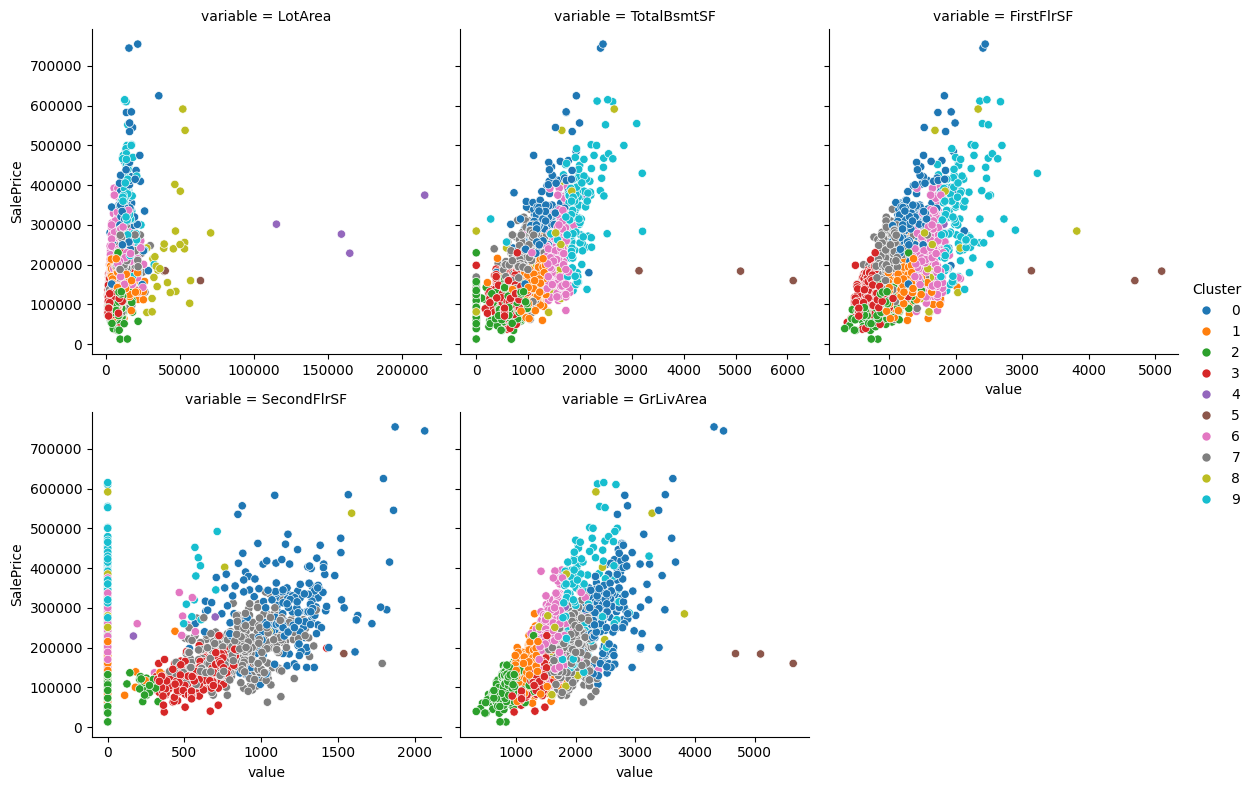

In [19]:
Xy = X.copy()
Xy["Cluster"] = Xy.Cluster.astype("category")
Xy["SalePrice"] = y
sns.relplot(
    x="value", y="SalePrice", hue="Cluster", col="variable",
    height=4, aspect=1, facet_kws={'sharex': False}, col_wrap=3,
    data=Xy.melt(
        value_vars=features, id_vars=["SalePrice", "Cluster"],
    ),
);

You can also add the distance to each cluster centre as a feature.

In [20]:
X_cd = kmeans.fit_transform(X_scaled)

# Label features and join to dataset
X_cd = pd.DataFrame(X_cd, columns=[f"Centroid_{i}" for i in range(X_cd.shape[1])])

In [21]:
X_new_1 = X_new.join(X_cd)
score_dataset(X_new_1, y)

np.float64(0.1782486768565753)

## Principle Component Analysis

Principal Component Analysis (PCA) is a linear dimensionality reduction technique, which simplifies a dataset by transforming it into a new coordinate system that highlights the most significant patterns in the data. Instead of describing the dataset in terms of the original variables, PCA re-expresses the data using its main axes of variation.

PCA transforms the original dataset linearly onto a new set of axes—called principal components—which capture the directions of maximum variance in the data. These components form an orthonormal basis, ensuring that each new axis represents a unique, uncorrelated source of variation in the dataset.

**How It Works**
First Principal Component: This is the direction in the data space along which the data varies the most. It is a linear combination of the original variables and explains the greatest amount of variance.

Subsequent Components: Each subsequent principal component captures the highest remaining variance under the constraint that it is orthogonal to all previous components. This continues until all variance in the dataset is accounted for.

The process yields as many principal components as there are original variables, but often only the first few are needed to capture most of the meaningful structure in the data.

PCA is commonly computed via eigendecomposition of the covariance matrix of the data or through singular value decomposition (SVD) of the data matrix. The eigenvectors of the covariance matrix represent the directions of the principal components, and the eigenvalues indicate the amount of variance each component captures. The loadings (the weights in the linear combinations) show how much each original variable contributes to a principal component.

In [22]:
from sklearn.decomposition import PCA

def apply_pca(X, standardize=True):
    # Standardize
    if standardize:
        X = (X - X.mean(axis=0)) / X.std(axis=0)
    # Create principal components
    pca = PCA()
    X_pca = pca.fit_transform(X)
    # Convert to dataframe
    component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
    X_pca = pd.DataFrame(X_pca, columns=component_names)
    # Create loadings
    loadings = pd.DataFrame(
        pca.components_.T,  # transpose the matrix of loadings
        columns=component_names,  # so the columns are the principal components
        index=X.columns,  # and the rows are the original features
    )
    return pca, X_pca, loadings

#### Example


In [23]:
features = [
    "GarageArea",
    "YearRemodAdd",
    "TotalBsmtSF",
    "GrLivArea",
]

print("Correlation with SalePrice:\n")
print(df[features].corrwith(df.SalePrice))

Correlation with SalePrice:

GarageArea      0.640138
YearRemodAdd    0.532974
TotalBsmtSF     0.632529
GrLivArea       0.706780
dtype: float64


In [24]:
X = X.loc[:, features]

pca, X_pca, loadings = apply_pca(X)
print(loadings)

                   PC1       PC2       PC3       PC4
GarageArea    0.541229 -0.102375 -0.038470  0.833733
YearRemodAdd  0.427077  0.886612 -0.049062 -0.170639
TotalBsmtSF   0.510076 -0.360778 -0.666836 -0.406192
GrLivArea     0.514294 -0.270700  0.742592 -0.332837


There are two ways you could use PCA for feature engineering.

The first way is to use it as a descriptive technique. Since the components tell you about the variation, you could compute the MI scores for the components and see what kind of variation is most predictive of your target. That could give you ideas for kinds of features to create -- a product of 'Height' and 'Diameter' if 'Size' is important, say, or a ratio of 'Height' and 'Diameter' if Shape is important. You could even try clustering on one or more of the high-scoring components.

The second way is to use the components themselves as features. Because the components expose the variational structure of the data directly, they can often be more informative than the original features. Here are some use-cases:

* Dimensionality reduction: When your features are highly redundant (multicollinear, specifically), PCA will partition out the redundancy into one or more near-zero variance components, which you can then drop since they will contain little or no information.
* Anomaly detection: Unusual variation, not apparent from the original features, will often show up in the low-variance components. These components could be highly informative in an anomaly or outlier detection task.
* Noise reduction: A collection of sensor readings will often share some common background noise. PCA can sometimes collect the (informative) signal into a smaller number of features while leaving the noise alone, thus boosting the signal-to-noise ratio.
* Decorrelation: Some ML algorithms struggle with highly-correlated features. PCA transforms correlated features into uncorrelated components, which could be easier for your algorithm to work with.

In [25]:
# Creating new features by adding pca
X_new_2 = X_new_1.join(X_pca)
score_dataset(X_new_2, y)

np.float64(0.16423130093603602)

In [26]:
# Examine MI-scores of pca
discrete_features = X_pca.dtypes == int
make_mi_scores(X_pca, y, discrete_features)

PC1    0.873403
PC3    0.340464
PC2    0.263815
PC4    0.089327
Name: MI Scores, dtype: float64

In [27]:
# Use high MI-score PCAs and information from loading to create new features
X_new_3 = X_new.copy()
X_new_3['pc1'] =  X.GarageArea + X.TotalBsmtSF + X.GrLivArea + X.YearRemodAdd
X_new_3['pc3'] = X.TotalBsmtSF * X.GrLivArea
X_new_3['pc2'] = (X.TotalBsmtSF+X.GrLivArea) * X.YearRemodAdd

score_dataset(X_new_3, y)

np.float64(0.1689289713547422)

PCA Best Practices

There are a few things to keep in mind when applying PCA:
* PCA only works with numeric features, like continuous quantities or counts.
* PCA is sensitive to scale. It's good practice to standardize your data before applying PCA, unless you know you have good reason not to.
* Consider removing or constraining outliers, since they can have an undue influence on the results.

##### Detecting Outliers

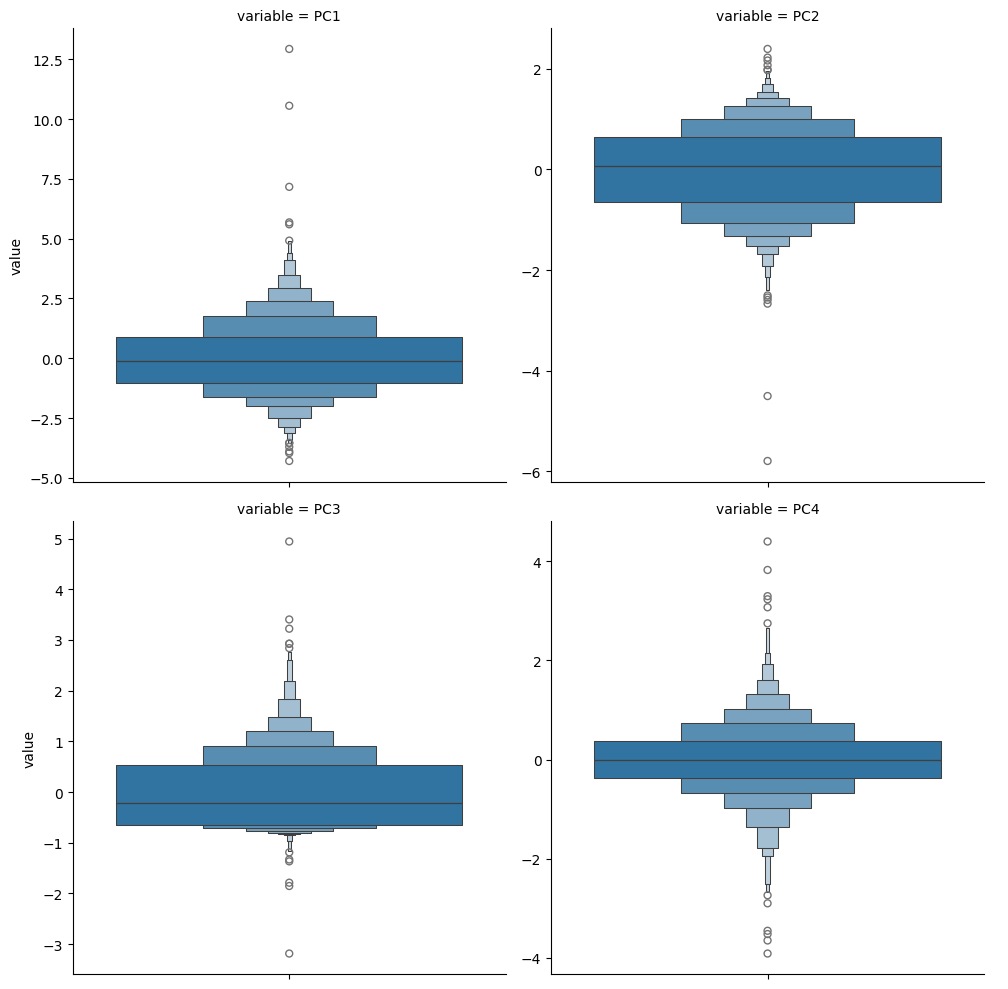

In [28]:
sns.catplot(
    y="value",
    col="variable",
    data=X_pca.melt(),
    kind='boxen',
    sharey=False,
    col_wrap=2,
);

As you can see, in each of the components there are several points lying at the extreme ends of the distributions -- outliers, that is.

In [29]:
#see those houses that sit at the extremes of a component and look for patterns, e.g. partial sales in Edwards --> these you might want to exclude from your model if you want to predict house values on the open market
component = "PC1"

idx = X_pca[component].sort_values(ascending=False).index
df.loc[idx, ["SalePrice", "Neighborhood", "SaleCondition"] + features]

,SalePrice,Neighborhood,SaleCondition,GarageArea,YearRemodAdd,TotalBsmtSF,GrLivArea
1498,160000,Edwards,Partial,1418.0,2008,6110.0,5642.0
2180,183850,Edwards,Partial,1154.0,2009,5095.0,5095.0
2181,184750,Edwards,Partial,884.0,2008,3138.0,4676.0
1760,745000,Northridge,Abnorml,813.0,1996,2396.0,4476.0
1767,755000,Northridge,Normal,832.0,1995,2444.0,4316.0
...,...,...,...,...,...,...,...
662,59000,Old_Town,Normal,0.0,1950,416.0,599.0
2679,80500,Brookside,Normal,0.0,1950,0.0,912.0
2879,51689,Iowa_DOT_and_Rail_Road,Abnorml,0.0,1950,0.0,729.0
780,63900,Sawyer,Normal,0.0,1950,0.0,660.0


## Target Encoding


A target encoding is any kind of encoding that replaces a feature's categories with some number derived from the target.

A simple and effective version is to apply a group aggregation like the mean. This kind of target encoding is sometimes called a mean encoding. Applied to a binary target, it's also called bin counting.

Use Cases for Target Encoding

* High-cardinality features: A feature with a large number of categories can be troublesome to encode: a one-hot encoding would generate too many features and alternatives, like a label encoding, might not be appropriate for that feature. A target encoding derives numbers for the categories using the feature's most important property: its relationship with the target.
* Domain-motivated features: From prior experience, you might suspect that a categorical feature should be important even if it scored poorly with a feature metric. A target encoding can help reveal a feature's true informativeness.

In [30]:
df.select_dtypes(["object"]).nunique().sort_values(ascending=False).head(10)

Neighborhood    28
Exterior2nd     17
Exterior1st     16
MSSubClass      16
SaleType        10
OverallQual     10
Condition1       9
OverallCond      9
RoofMatl         8
Functional       8
dtype: int64

Target encoding presents a couple of problems, however. First are unknown categories. Target encodings create a special risk of overfitting, which means they need to be trained on an independent "encoding" split (else: in an extreme case you would just encode your target variable and learn that encoding). When you join the encoding to future splits, Pandas will fill in missing values for any categories not present in the encoding split. These missing values you would have to impute somehow.

In [31]:
# Encoding split
X_encode = df.sample(frac=0.20, random_state=0)
y_encode = X_encode.pop("SalePrice")

# Training split
X_pretrain = df.drop(X_encode.index)
y_train = X_pretrain.pop("SalePrice")

Second are rare categories. When a category only occurs a few times in the dataset, any statistics calculated on its group are unlikely to be very accurate. Target encoding rare categories can make overfitting more likely.

In [32]:
df["SaleType"].value_counts()

SaleType
WD       2536
New       239
COD        87
ConLD      26
CWD        12
ConLI       9
ConLw       8
Oth         7
Con         5
VWD         1
Name: count, dtype: int64



#### Smoothing

A solution to these problems is to add smoothing. The idea is to blend the in-category average with the overall average. Rare categories get less weight on their category average, while missing categories just get the overall average.

In pseudocode:

encoding = weight * in_category + (1 - weight) * overall

An easy way to determine the value for weight is to compute an m-estimate:

weight = n / (n + m)
where n is the total number of times that category occurs in the data. The parameter m determines the "smoothing factor". Larger values of m put more weight on the overall estimate. When choosing a value for m, consider how noisy you expect the categories to be. Would you need a lot of data to get good estimates? If so, it could be better to choose a larger value for m.

In [56]:
from category_encoders import MEstimateEncoder

# Create the MEstimateEncoder
# Choose a set of features to encode and a value for m
encoder = MEstimateEncoder(cols=["SaleType", 'Neighborhood', 'Exterior2nd', 'Exterior1st'], m=1.0)


# Fit the encoder on the encoding split
encoder.fit(X_encode, y_encode)

# Encode the training split
X_train = encoder.transform(X_pretrain, y_train)

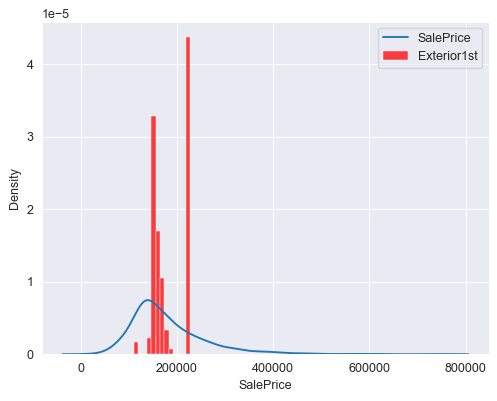

In [77]:
feature = 'Exterior1st'

plt.figure(dpi=90)
ax = sns.kdeplot(y_train, label="SalePrice")
sns.histplot(X_train[feature], color='r', stat="density", ax=ax, label =feature)
ax.set_xlabel("SalePrice")
ax.legend()

If your encoded feature’s distribution (red histogram) overlaps well with the target distribution (blue KDE), that means:

* The encoding is effectively capturing the target's distribution.
* The encoded values (i.e., category-level means) reflect meaningful variation in the target.
* Your model can use this feature directly and benefit from it.

If the encoded feature has a very flat or random distribution, or does not align at all with the shape of the target (y_train), this may indicate:
* The category doesn't correlate much with SalePrice.
* The encoding could be introducing noise.


Here the loss of data due to the encoding was worth it:

In [78]:
score_base = score_dataset(X, y)
score_new = score_dataset(X_train, y_train)

print(f"Baseline Score: {score_base:.4f} RMSLE")
print(f"Score with Encoding: {score_new:.4f} RMSLE")

Baseline Score: 0.1957 RMSLE
Score with Encoding: 0.1437 RMSLE
